In [117]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import random

from similarity.jaccard import Jaccard
from similarity.normalized_levenshtein import NormalizedLevenshtein
from sklearn.feature_extraction.text import TfidfVectorizer 

#### Load Recipes Data

In [118]:
recipes = json.load(open('./data/recipe_train.json'))

#### Convert recipe to text document

In [119]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [120]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [121]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

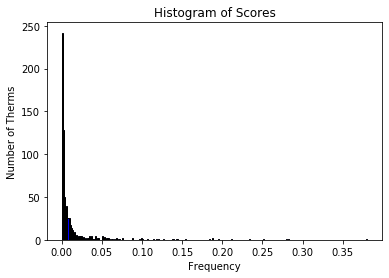

In [122]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [130]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    print('-------------')
    print(k)
    print(scores_df.iloc[:10,:])


-------------
greek
     term     score
0   fresh  0.297130
1  pepper  0.294340
2     oil  0.287714
3    salt  0.260512
4   olive  0.260163
5    feta  0.231165
6  ground  0.226684
7   lemon  0.224591
8  garlic  0.220058
9  cheese  0.202621
-------------
southern_us
     term     score
0    salt  0.374617
1  pepper  0.329929
2   sugar  0.285364
3  butter  0.265297
4   flour  0.227380
5  ground  0.189832
6    eggs  0.170627
7  powder  0.160286
8     oil  0.157209
9     all  0.155608
-------------
filipino
     term     score
0   sauce  0.327662
1  garlic  0.325087
2  pepper  0.323156
3    salt  0.309637
4     oil  0.306418
5  onions  0.252988
6   water  0.224020
7   sugar  0.205352
8     soy  0.186683
9  ground  0.173165
-------------
indian
     term     score
0  ground  0.356060
1    salt  0.304793
2     oil  0.259010
3  garlic  0.208764
4   fresh  0.208637
5   cumin  0.199327
6  masala  0.198498
7  powder  0.191293
8  ginger  0.188105
9   garam  0.181433
-------------
jamaican
       

#### Load Baskets Market Data

In [124]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append(row)

#### Compute Basket Scores
For each basket we iterate over all items and 
compute their similarities with all therms that scored 
more than zero in the cuisines docs


In [129]:
baskets_scores = []
random_sample = random.sample(baskets,25)
for basket in random_sample:
    similarities = {}
    for cuisine in docs_scores_dfs.keys():
        scores_df = docs_scores_dfs[cuisine]
        scores_df = scores_df.sort_values(by=['score'],ascending=False)
        scores_df = scores_df[scores_df['score']>(statistics[cuisine][1]/4)]
        for item in basket:  
            scores = []
            weights = []
            for index, row in scores_df.iterrows():
                [term, score] = [row['term'], row['score']]
                #metric = NormalizedLevenshtein()
                metric = Jaccard(3)
                if metric != 0:
                    weights.append(metric.similarity(item, term))
                    scores.append(score)
            # weighted avg using similarities as weights
        weights_sum = sum(weights)
        if weights_sum != 0.0:
            #similarities[cuisine] = sum([a*b for a,b in zip(scores,weights)])
            similarities[cuisine] = sum([a*b for a,b in zip(scores,weights)])/weights_sum
        else:
            similarities[cuisine] = 0.0
    baskets_scores.append(similarities)
        
    print('------------------')
    print("basket: ", basket)
    print("similarities: ")
    for k in similarities:
        print(k, similarities[k])
                

------------------
basket:  ['pip fruit', 'whole milk']
similarities: 
greek 0.22459148190830458
southern_us 0.12670345403205763
filipino 0.12295360778801849
indian 0.0
jamaican 0.0
spanish 0.0
italian 0.0
mexican 0.0
chinese 0.0
british 0.19539965760302372
thai 0.14128169627756826
vietnamese 0.0
cajun_creole 0.0
brazilian 0.26380801650353264
french 0.10155741685610384
japanese 0.0
irish 0.13376567394567343
korean 0.0
moroccan 0.17634716912329307
russian 0.10884505525530551
------------------
basket:  ['whole milk', 'processed cheese', 'pastry', 'soda']
similarities: 
greek 0.0
southern_us 0.0
filipino 0.0
indian 0.0
jamaican 0.0
spanish 0.0
italian 0.0
mexican 0.0
chinese 0.0
british 0.0
thai 0.0
vietnamese 0.0
cajun_creole 0.0
brazilian 0.0
french 0.0
japanese 0.0
irish 0.10591361728680661
korean 0.0
moroccan 0.0
russian 0.0
------------------
basket:  ['rolls/buns', 'coffee']
similarities: 
greek 0.0
southern_us 0.0
filipino 0.0
indian 0.0
jamaican 0.0
spanish 0.0
italian 0.0
mexica